In [101]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
import lsst.afw.image as afwImage
from lsst.afw.table import BaseCatalog

import data_process_utils as dpu

import os
import glob
import sqlite3
from numpy import unravel_index
import pandas as pd
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

In [102]:
# sigma = fwhm / np.sqrt(8 * np.log(2))

def dipole_func(x, u, sigma):
    y = 1 / sigma / np.sqrt(2 * np.pi) * ( np.exp( - 1 / 2 * (x - u)**2 / sigma**2 ) - np.exp( - 1 / 2 * x**2 / sigma**2 ) )
    return y

def plot_Gaussian_pair(x, u, sigma, ax):
    y1 = 1 / sigma / np.sqrt(2 * np.pi) * np.exp( - 1 / 2 * x**2 / sigma**2 )
    y2 = 1 / sigma / np.sqrt(2 * np.pi) * np.exp( - 1 / 2 * (x - u)**2 / sigma**2 )
    ax.plot(x, y1, color='g', label=f'N(0, {sigma})')
    ax.plot(x, y2, color='r', label=f'N({u}, {sigma})')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    
def plot_dipole(x, u, sigma, ax):
    y = dipole_func(x=x, u=u, sigma=sigma)
    ax.plot(x, y, label=f'u = {u},  sigma = {sigma}')
    x_min, x_max = x[np.argmin(y)], x[np.argmax(y)]
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axvline(x=x_min, color='gray', label='peak x')
    ax.axvline(x=x_max, color='gray')
    ax.legend();
    ax.set_xlabel('x')
    ax.set_ylabel(f'N({u}, {sigma}) - N({0}, {sigma})')

def plot_pos_res_vs_sigma(u_arr, ax):
    sigma_ls = [0.5, 2, 5]
    color_ls = ['r', 'g', 'cyan', 'blue']
    for idx, sigma in enumerate(sigma_ls):
        pos_res_ls = []
        for u in u_arr:
            pos_res, _ = quad(dipole_func, u / 2, float('inf'), args=(u , sigma))
            pos_res_ls.append(pos_res)
        ax.plot(u_arr, pos_res_ls, color=color_ls[idx], label = f'$\sigma$ = {sigma}')
    ax.set_xlabel('Pixel Separation', size=14)
    ax.set_ylabel('Fraction of Positive Flux to Total Flux', size=14)
    ax.axhline(y=0.01, color='gray', label = 'y=0.01')
    ax.legend()
    
def plot_peak_x(u_arr, ax, show_legend=True):
    color_ls = ['r', 'orange', 'g', 'cyan', 'blue', 'purple', 'k']
    sigma_ls = [0.5, 2, 5]
    x_arr = np.arange(-50, 50, 0.001)
    for idx, sigma in enumerate(sigma_ls):
        color = color_ls[idx]
        peak_pos_x_ls = []
        peak_neg_x_ls = []
        for u in u_arr:
            flux = dipole_func(x_arr, u, sigma)
            peak_pos_x = x_arr[np.argmax(flux)]
            peak_neg_x = x_arr[np.argmin(flux)]
            peak_pos_x_ls.append(peak_pos_x)
            peak_neg_x_ls.append(peak_neg_x)
        ax.plot(u_arr, peak_pos_x_ls, color=color, label = f'$\sigma$ = {sigma}')  
        ax.plot(u_arr, peak_neg_x_ls, linestyle = 'dashed', color=color)
        ax.text(-0.01, sigma, f'{sigma}', color=color)
        ax.text(-0.01, -sigma, f'-{sigma}', color=color)
        ax.axhline(y=sigma, xmin=-0.1, xmax=0.1, linestyle='dotted', color='k')
        ax.axhline(y=-sigma, xmin=-0.1, xmax=0.1, linestyle='dotted', color='k')
    
    ax.set_xlabel('Pixel Separation', size=14)
    ax.set_ylabel('Peak X', size=14)
    if show_legend:
        ax.legend(fontsize=12)    
        
def cal_psf_sigma_from_exp(exp):
    psf = exp.getPsf()
    psf_shape = psf.computeShape()
    ixx = psf_shape.getIxx()
    iyy = psf_shape.getIyy()
    psf_sigma = np.sqrt(( ixx + iyy) / 2 )
    return psf_sigma

def find_peak_idx_of_image(image, kind):
    if kind == 'max':
        row, col = unravel_index(image.argmax(), image.shape)
    elif kind == 'min':
        row, col = unravel_index(image.argmin(), image.shape)
    else:
        print("kind should be 'max' or 'min'")
        return
    return row, col

        
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter',
             'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_suspectCenter',
             'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge','base_PixelFlags_flag_bad']
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
def remove_flag_astropy(src_table, flag_list=None):

    src_df = src_table.to_pandas()
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) == 0).to_numpy()
    src_df = src_df[keep_id].copy().reset_index(drop=True)
    flag_removed =  Table.from_pandas(src_df)
    return flag_removed
def keep_flag_astropy(src_table, flag_list=None):

    src_df = src_table.to_pandas()
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) >0).to_numpy()
    src_df = src_df[keep_id].copy().reset_index(drop=True)
    flag_removed =  Table.from_pandas(src_df)
    return flag_removed

Define a dipole artifact (D) as the residual between two Gaussian with separation $u$, we have:

$D = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}[(\frac{x-u}{\sigma})^2 + (\frac{y}{\sigma})^2]} - \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}[(\frac{x}{\sigma})^2 + (\frac{y}{\sigma})^2]}$.

An example is shown below.

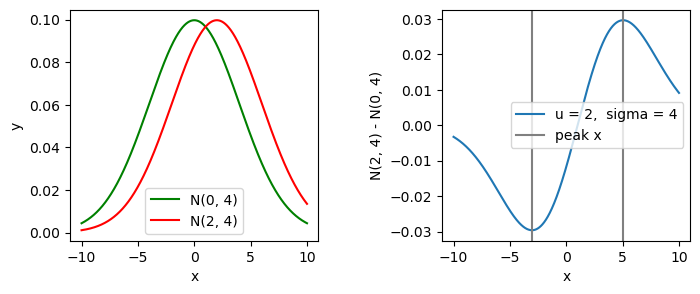

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
fig.subplots_adjust(wspace=0.5)
x = np.arange(-10,10,0.001)
u, sigma = 2, 4
plot_Gaussian_pair(x, u, sigma, ax[0])
plot_dipole(x, u, sigma, ax[1])

Due to symmetry, we focus on the positive side. Require $D > 0$, we have $x > \frac{u}{2}$. Integrate over the positive region, the integral in the $y$ direction is $1$, so we only care about the integral in the $x$ direction.

$
\int_{-\infty}^{+\infty} D dx dy = \int_{-\infty}^{+\infty} \int_{\frac{u}{2}}^{+\infty} ( \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}[(\frac{x-u}{\sigma})^2 + (\frac{y}{\sigma})^2]} - \frac{1}{\sigma \sqrt{2\pi}} e^{-[\frac{1}{2}(\frac{x}{\sigma})^2 + (\frac{y}{\sigma})^2]} ) dx dy = \int_{\frac{u}{2}}^{+\infty} ( \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}(\frac{x-u}{\sigma})^2} - \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}(\frac{x}{\sigma})^2} ) dx
$.

Simulation of the positive integral with respect to the pixel separation is shown below.

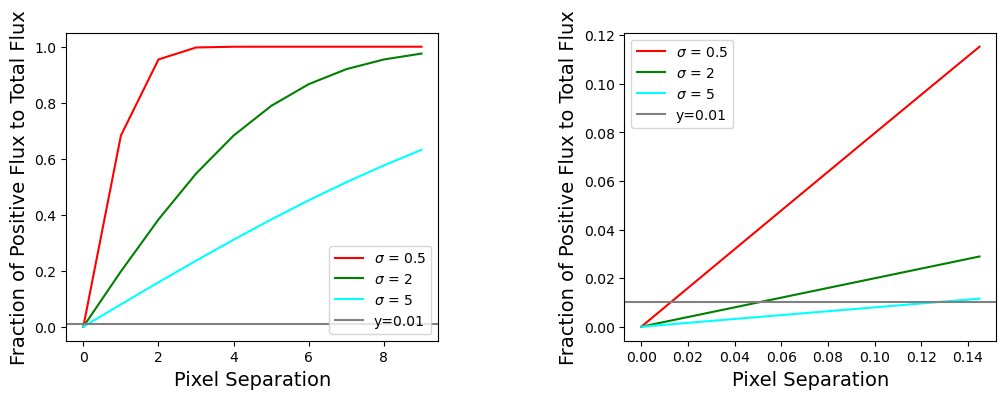

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=0.5)

u_arr_1 = np.arange(0, 10, 1)
u_arr_2 = np.arange(0, 0.15, 0.005)
plot_pos_res_vs_sigma(u_arr_1, ax[0])
plot_pos_res_vs_sigma(u_arr_2, ax[1])

We find that the fraction of positive residual increases monotonically with pixel separation. The residual is approaching 1 at large separation. A dipole from sharper Gaussians (small $\sigma$) increases faster than the a dipole from broader Gaussian (large $\sigma$).

Next we explore the relationship between the positions of peak pixels with pixel separation. We begin our analysis with simulation.

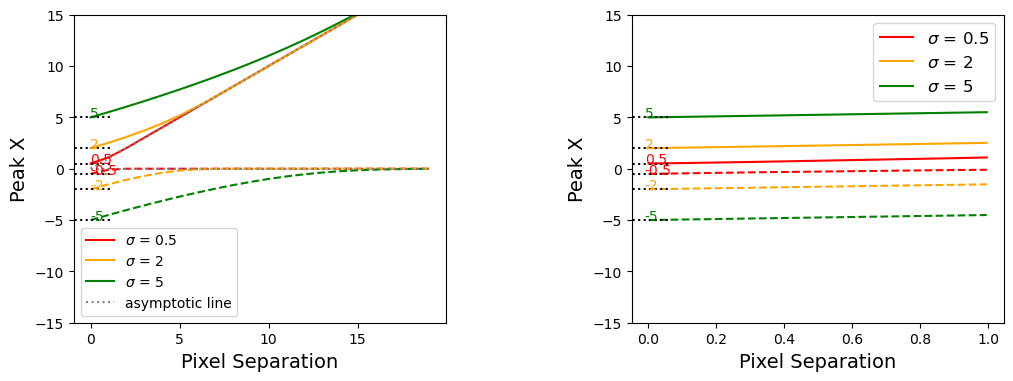

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.5)

u_arr_1 = np.arange(0.001, 20, 1)
u_arr_2 = np.arange(0.001, 1, 0.005)
plot_peak_x(u_arr_1, ax[0])
plot_peak_x(u_arr_2, ax[1])
ylim = 15
ax[0].set_ylim((-ylim, ylim))
ax[1].set_ylim((-ylim, ylim))
ax[0].plot(u_arr_1, u_arr_1, color='gray', linestyle='dotted', label='asymptotic line')
ax[0].plot(u_arr_1, np.zeros(len(u_arr_1)), color='gray', linestyle='dotted')
ax[0].legend();

We plot the position of peak x as a function of pixel separation. Positive peak positions converge to $y=x$ and negative peak positions converge to $y=0$. This is because the further separation they are, the less interactions between two Gaussians. As a result, peak positions will converge to centers of two Gaussians. 

For separation within one pixel, however, we found that the peak positions of x have sudden jump from 0 to the $\pm \sigma$ of the corresponding Gaussian. It is slightly counter intuitive that the limiting value of peak x position is not 0. We plot some dipoles to explore this issue.

We start with $\sigma=5$

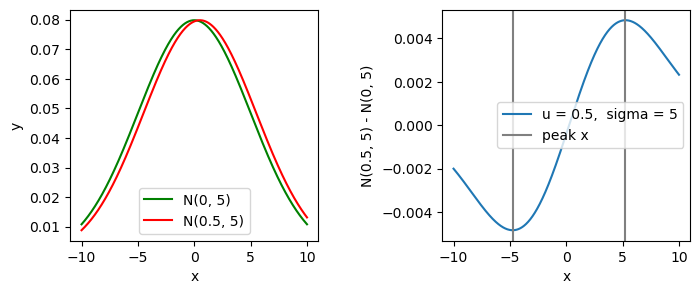

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
fig.subplots_adjust(wspace=0.5)
x = np.arange(-10,10,0.001)
u, sigma = 0.5, 5
plot_Gaussian_pair(x, u, sigma, ax[0])
plot_dipole(x, u, sigma, ax[1])

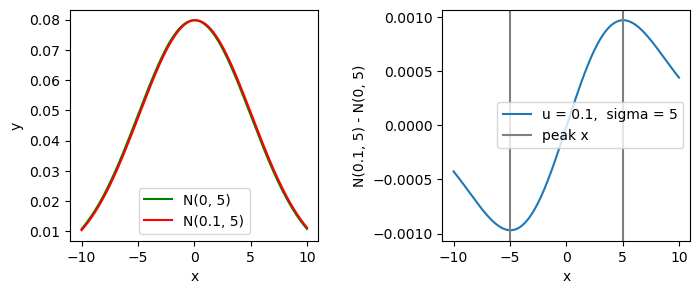

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
fig.subplots_adjust(wspace=0.5)
x = np.arange(-10,10,0.001)
u, sigma = 0.1, 5
plot_Gaussian_pair(x, u, sigma, ax[0])
plot_dipole(x, u, sigma, ax[1])

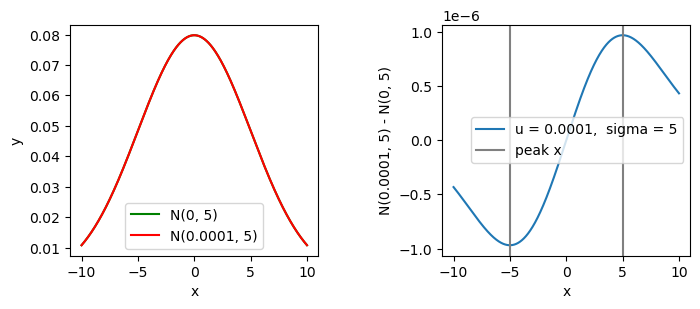

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
fig.subplots_adjust(wspace=0.5)
x = np.arange(-10,10,0.001)
u, sigma = 0.0001, 5
plot_Gaussian_pair(x, u, sigma, ax[0])
plot_dipole(x, u, sigma, ax[1])

Next we try $\sigma=0.1$

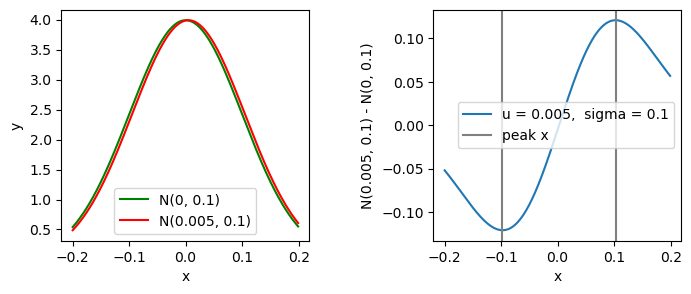

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
fig.subplots_adjust(wspace=0.5)
x = np.arange(-0.2,0.2,0.001)
u, sigma = 0.005, 0.1
plot_Gaussian_pair(x, u, sigma, ax[0])
plot_dipole(x, u, sigma, ax[1])

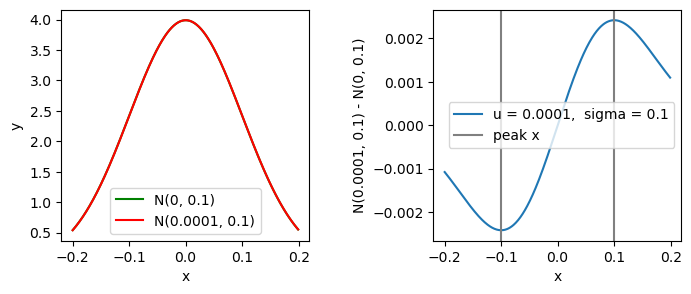

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
fig.subplots_adjust(wspace=0.5)
x = np.arange(-0.2,0.2,0.001)
u, sigma = 0.0001, 0.1
plot_Gaussian_pair(x, u, sigma, ax[0])
plot_dipole(x, u, sigma, ax[1])

Above plots confirm that the limiting value of peak x position is the standard deviation $\sigma$ of the corrsponding Gaussian. The magnitude of the dipole decrease as u decrease, which peak x converges to $\pm \sigma$. This observation implies that even subpixel registration error could produce dipole artifacts for bright starts. Next, we prove this result mathematically.

As we defined above, a dipole artifact (D) is the residual between two Gaussian with separation $u$,

$D = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}[(\frac{x-u}{\sigma})^2 + (\frac{y}{\sigma})^2]} - \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}[(\frac{x}{\sigma})^2 + (\frac{y}{\sigma})^2]}$.

The peak position of x can be solved by requiring the first derivative of $D$ to be zero,

$ 0 = \frac{\partial D}{\partial x} = e^{-\frac{1}{2\sigma^2}(u^2-2xu)}(u-x) + x $.

Reorganize the equation, we have

$\frac{1}{1-\frac{u}{x}} = e^{-\frac{u^2}{2\sigma^2}}e^{\frac{xu}{\sigma^2}}$.

which cannot be solved analytically. The right hand side (RHS) is an exponential function scaled by $e^{-\frac{u^2}{2\sigma^2}}$. The behavior of the left hand side (LHS) $\frac{1}{1-\frac{u}{x}}$ is shown below.

| $x<0$   | $-\frac{u}{x}: 0 \rightarrow +\infty$ |  $1 -\frac{u}{x}: 1 \rightarrow +\infty$ | $\frac{1}{1-\frac{u}{x}}: 1 \rightarrow 0$ |

| $x=0$   | $-\frac{u}{x}$: None | $1 -\frac{u}{x}$: None | $\frac{x}{x-u}=0$ |

| $0<x<u$ | $-\frac{u}{x}: -\infty \rightarrow -1$ |  $1 -\frac{u}{x}: -\infty \rightarrow 0$ | $\frac{1}{1-\frac{u}{x}}: 0 \rightarrow -\infty$ |

| $x = u$ | $-\frac{u}{x}$: None | $1 -\frac{u}{x}$:  None | $\frac{1}{1-\frac{u}{x}}$: None |

| $x>u$ | $-\frac{u}{x}: -1 \rightarrow 0$ |  $1 -\frac{u}{x}: 0 \rightarrow 1$ | $\frac{1}{1-\frac{u}{x}}: +\infty \rightarrow 1$ |

Below we show a simulation of the LHS and RHS.

In [14]:
def lhs(x, u):
    return x / (x-u)
def rhs(x, u, sigma):
    return np.exp( - (u**2 / 2 / sigma**2) ) * np.exp( x*u / sigma**2)

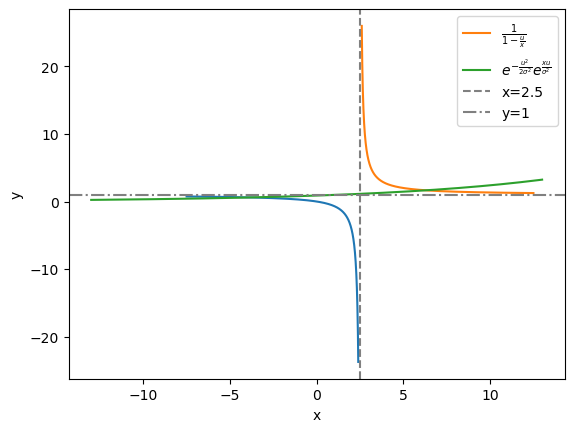

In [15]:
u = 2.5
sigma = 5
x_left_1 = np.arange(u-10, u-0.1,0.001)
x_left_2 = np.arange(u+0.1, u+10, 0.001)
y_left_1 = lhs(x_left_1, u)
y_left_2 = lhs(x_left_2, u)

x_right = np.arange(-13, 13, 0.001)
y_right = rhs(x_right, u, sigma)

plt.plot(x_left_1, y_left_1)
plt.plot(x_left_2, y_left_2, label=r'$\frac{1}{1-\frac{u}{x}}$')
plt.plot(x_right, y_right, label=r'$e^{-\frac{u^2}{2\sigma^2}}e^{\frac{xu}{\sigma^2}}$')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(x=u, linestyle='dashed', color='gray', label=f'x={u}')
plt.axhline(y=1, linestyle='dashdot', color='gray', label='y=1')
plt.legend()

Now we solve $\frac{1}{1-\frac{u}{x}} = e^{-\frac{u^2}{2\sigma^2}}e^{\frac{xu}{\sigma^2}}$ for small $u$.

Expand LHS and RHS to the 1st order of $u$, we have.

LHS = $\frac{1}{1-\frac{u}{x}} = 1 + \frac{u}{x} + \ldots$,

RHS = $e^{-\frac{u^2}{2\sigma^2}}e^{\frac{xu}{\sigma^2}} = 1 + \frac{ux}{\sigma^2} + \ldots$.

Require LHS = RHS, we have

$\frac{u}{x} = \frac{ux}{\sigma^2}$,

which has two solutions

$x=\pm \sigma$.

Next, we explore this relationship using artifacts from DC2 dataset.

In [21]:
config = 'al_default_v23'
db = (
    f'./data'
    f'/patch_0to6/diff/{config}/detection/detection.sqlite'
)
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)

In [22]:
art_astropy = Table.from_pandas(art)
sat_rm = remove_flag_astropy(art_astropy, flag_list=base_flags)
dipole_keep = keep_flag_astropy(sat_rm, flag_list=dipole_flags)

In [100]:
print(len(dipole_keep))

361


In [99]:
"""
star_sep_ls = []
# separation of peak positions of dipoles
peak_sep_ls = []
calexp_psf_2sigma_ls = []
for row in dipole_keep:
    patch, host_mag, fake_mag_str = str(row['patch']), str(row['host_mag']), str(row['fake_mag'])
    visit, det, filt = int(row['visit']), int(row['detector']), str(row['filter'])
    
    fake_dir = ('./data/patch_0to6/injection'
                f'/{patch}_{host_mag}_{visit}_{det}_{filt}/fake_{fake_mag_str}/calexp/*/*/*.fits')
    calexp_path = glob.glob(fake_dir)[0]
    calexp_exp = afwImage.ExposureF(calexp_path)
    calexp_psf_2sigma = 2 * cal_psf_sigma_from_exp(calexp_exp)
    calexp_psf_2sigma_ls.append(calexp_psf_2sigma)  
    
    diff_dir = './data/patch_0to6/diff/al_default_v23'
    diff_repo = os.path.join(
    diff_dir,  f'{patch}_{host_mag}_{visit}_{det}_{filt}/diff_{fake_mag_str}'
    )
    diffexp_dir = f'{diff_repo}/deepDiff/*/*/diffexp*'
    diffexp_path = glob.glob(diffexp_dir)[0]
    diff_exp = afwImage.ExposureF(diffexp_path)  
    x, y = row['base_NaiveCentroid_x'], row['base_NaiveCentroid_y']
    diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
    diff_stamp_image = diff_stamp.getImage().array    
    peak_pos_row, peak_pos_col = find_peak_idx_of_image(diff_stamp_image, 'max')
    peak_neg_row, peak_neg_col = find_peak_idx_of_image(diff_stamp_image, 'min')    
    peak_sep = np.sqrt((peak_pos_row - peak_neg_row)**2 + (peak_pos_col - peak_neg_col)**2)
    peak_sep_ls.append(peak_sep)
    
    star_1_x = row['ip_diffim_DipoleFit_pos_centroid_x']
    star_1_y = row['ip_diffim_DipoleFit_pos_centroid_y']
    star_2_x = row['ip_diffim_DipoleFit_neg_centroid_x']
    star_2_y = row['ip_diffim_DipoleFit_neg_centroid_y']
    star_sep = np.sqrt((star_1_x - star_2_x)**2 + (star_1_y - star_2_y)**2)
    # star_sep = row['ip_diffim_DipoleFit_separation']
    star_sep_ls.append(star_sep)
df = pd.DataFrame({'psf_sep': calexp_psf_2sigma_ls,
                   'peak_sep': peak_sep_ls,
                   'star_sep': star_sep_ls})
df.to_csv('dipole_separation.csv', index=False)
""";

We analyzed 361 artifacts which have no saturation flag set to True but have dipole flags set to True. Next two plots provide evidences which support our results.

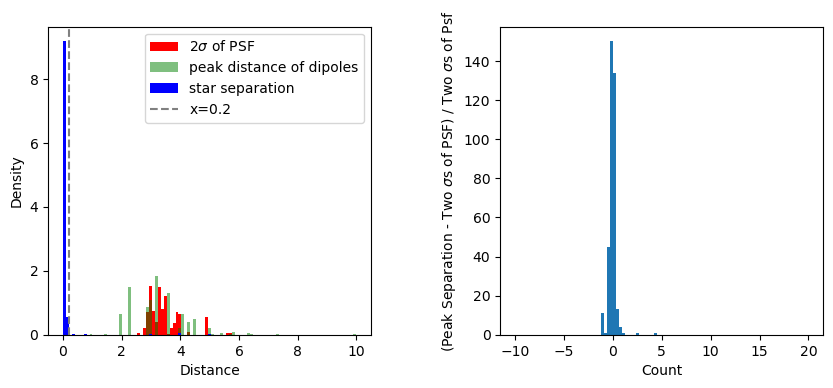

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.4)
dipole_sep_df = pd.read_csv('./dipole_separation.csv')
ax[0].hist(dipole_sep_df['psf_sep'], bins=np.linspace(0,10,100), density=True,
         color='r', label='2$\sigma$ of PSF');
ax[0].hist(dipole_sep_df['peak_sep'], bins=np.linspace(0,10,100), density=True,
         color='g', label='peak distance of dipoles', alpha=0.5)
ax[0].hist(dipole_sep_df['star_sep'], bins=np.linspace(0,10,100), density=True,
         color='blue', label='star separation')
x_threshold = 0.2
ax[0].axvline(x=x_threshold, color='gray', linestyle='dashed', label=f'x={x_threshold}')
ax[0].set_xlabel('Distance')
ax[0].set_ylabel('Density')
ax[0].legend()
sep_res = (dipole_sep_df['peak_sep'] - dipole_sep_df['psf_sep']) / dipole_sep_df['psf_sep']
ax[1].hist(sep_res, bins = np.linspace(-10, 20, 100));
ax[1].set_xlabel('Count')
ax[1].set_ylabel('(Peak Separation - Two $\sigma$s of PSF) / Two $\sigma$s of Psf');

Conclusion: The distance of peak positions of dipole artifacts approach to two $\pm\sigma$s when the separation of the original stars are small. $\sigma$ is the standard deviation of the Gaussian stars. The peak distance increases as the star separation increases. The asymptotic lines of the positive peak position and the negative position are $y=x$ and $y=0$.